# MNIST Assignment

In [1]:
import numpy as np
import matplotlib.pyplot as plt

## Chapeter 3 - 신경망

### Activation function

In [2]:
def step(x):
    return np.array(x > 0, dtype=np.int32)

def sigmoid(x):
    return np.array(1 / (1 + np.exp(-x)))

def relu(x):
    return np.array(np.maximum(0, x))

def softmax(x):
    t = np.exp(x - np.max(x))
    return np.array(t / np.sum(t))

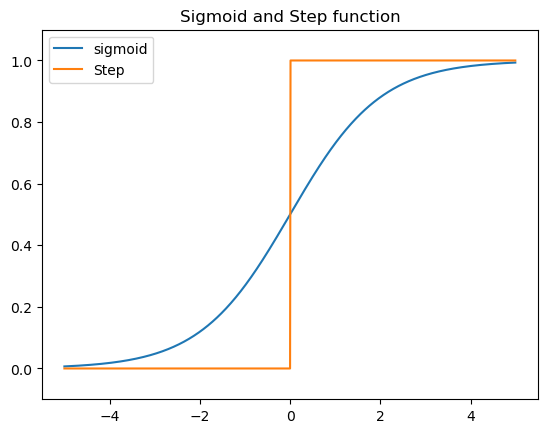

In [3]:
x = np.arange(-5, 5, 0.01)
y_sigmoid = sigmoid(x)
y_step = step(x)

plt.plot(x, y_sigmoid, label="sigmoid")
plt.plot(x, y_step, label="Step")
plt.legend()
plt.ylim(-0.1, 1.1)
plt.title("Sigmoid and Step function")
plt.show()

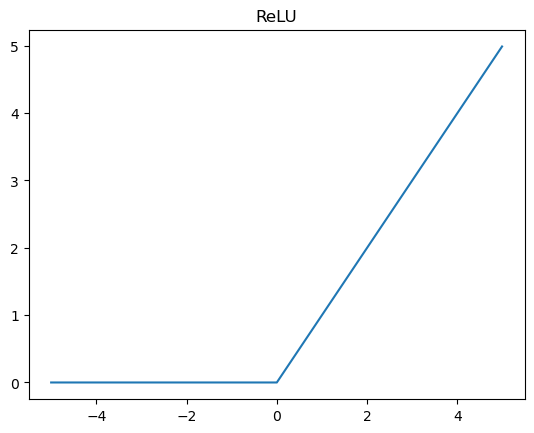

In [4]:
y_relu = relu(x)
plt.plot(x, y_relu)
plt.title("ReLU")
plt.show()

### Example neural network at chapter 3.4

In [5]:
def init_network():
    network = {}
    network["W1"] = np.array([[0.1, 0.3, 0.5], [0.2, 0.4, 0.6]])
    network["B1"] = np.array([0.1, 0.2, 0.3])
    network["W2"] = np.array([[0.1, 0.4], [0.2, 0.5], [0.3, 0.6]])
    network["B2"] = np.array([0.1, 0.2])
    network["W3"] = np.array([[0.1, 0.3], [0.2, 0.4]])
    network["B3"] = np.array([0.1, 0.2])
    
    return network
    
def forward(X, network, activation_fn, output_classifier):
    W1, W2, W3 = network["W1"], network["W2"], network["W3"]
    B1, B2, B3 = network["B1"], network["B2"], network["B3"]
    
    a1 = np.dot(X, W1) + B1
    z1 = activation_fn(a1)
    a2 = np.dot(z1, W2) + B2
    z2 = activation_fn(a2)
    a3 = np.dot(z2, W3) + B3
    y = output_classifier(a3)
    
    return y

In [6]:
network = init_network()
x = np.array([1.0, 0.5])
y = forward(x, network, sigmoid, softmax)

print(y)

[0.40625907 0.59374093]


### Load MNIST Dataset

In [7]:
import pickle
from data.load_mnist import load_mnist

def get_data():
    (X_train, T_train), (X_test, T_test) = load_mnist()
    return X_test, T_test


### Example neural network at chapter 3.6

In [8]:
def init_network():
    with open("data/sample_weight.pkl", "rb") as f:
        return pickle.load(f)

def predict(network, X, activation_fn, output_classifier):
    W1, W2, W3 = network["W1"], network["W2"], network["W3"]
    B1, B2, B3 = network["b1"], network["b2"], network["b3"]

    a1 = np.dot(X, W1) + B1
    z1 = activation_fn(a1)
    a2 = np.dot(z1, W2) + B2
    z2 = activation_fn(a2)
    a3 = np.dot(z2, W3) + B3
    y = output_classifier(a3)

    return y

In [9]:
X, T = get_data()
network = init_network()

batch_size = 100
accuracy_count = 0

for i in range(0, len(X), batch_size):
    Y_batch = predict(network, X[i:i+batch_size], sigmoid, softmax)
    p = np.argmax(Y_batch, axis=1)
    
    accuracy_count += np.sum(p == T[i:i+batch_size])
        
print(f"Accuracy: {float(accuracy_count) / len(X)}")

Accuracy: 0.9352


## Chapter 4 - 신경망 학습

### Loss Function

In [10]:
def sse(y, t):
    return np.sum(np.square(y - t)) / 2

def cee(y, t, delta=1e-7):
    return -np.sum(t * np.log(y + delta))

In [11]:
y = np.array([0.1, 0.05, 0.6, 0.0, 0.05, 0.1, 0.0, 0.1, 0.0, 0.0])
t = np.array([0, 0, 1, 0, 0, 0, 0, 0, 0, 0])
print(sse(y, t))
t2 = np.array([0, 0, 0, 0, 0, 0, 0, 1, 0, 0])
print(sse(y, t2))

0.09750000000000003
0.5975


In [12]:
print(cee(y, t))
print(cee(y, t2))

0.510825457099338
2.302584092994546


### Mini Batch

In [13]:
(X_train, T_train), (X_test, T_test) = load_mnist(normalize=True, one_hot_label=True)

train_size = X_train.shape[0]
batch_size = 10
batch_mask = np.random.choice(train_size, batch_size)

X_batch = X_train[batch_mask]
T_batch = T_train[batch_mask]

In [14]:
def cee(y, t, delta=1e-7):
    if y.ndim == 1:
        y = y.reshape(1, y.size)
        t = t.reshape(1, t.size)
    
    batch_size = y.shape[0]
    return -np.sum(np.log(y[np.arange(batch_size), t] + delta)) / batch_size

### Differential - Chapter 4.3

In [15]:
def numerical_diff(f, x, delta_x=1e-4):
    return (f(x+delta_x) - f(x-delta_x)) / (2 * delta_x)

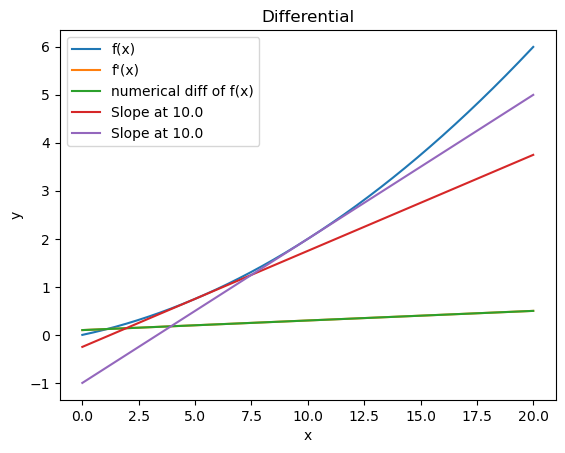

In [16]:
def f(x):
    return 0.01 * (x ** 2) + 0.1 * x

def df(x):
    return 0.02 * x + 0.1

def slope(f, x):
    d = numerical_diff(f, x)
    y = f(x) - d * x
    return lambda t: d * t + y

x = np.arange(0.0, 20.0, 0.01)
y = f(x)
dy = df(x)
numerical_diff_y = numerical_diff(f, x)
tangent_f_at_5 = slope(f, 5)
tangent_line_5 = tangent_f_at_5(x)
tangent_f_at_10 = slope(f, 10)
tangent_line_10 = tangent_f_at_10(x)

plt.plot(x, y, label="f(x)")
plt.plot(x, dy, label="f'(x)")
plt.plot(x, numerical_diff_y, label="numerical diff of f(x)")
plt.plot(x, tangent_line_5, label="Slope at 10.0")
plt.plot(x, tangent_line_10, label="Slope at 10.0")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.title("Differential")
plt.show()

### Partial Differential - Chapter 4.4

In [17]:
def _numerical_gradient_no_batch(f, x, delta_x):
    grad = np.zeros_like(x)
    
    for i in range(x.size):
        x[i] += delta_x
        fxh1 = f(x)
        
        x[i] -= 2 * delta_x
        fxh2 = f(x)
        
        grad[i] = (fxh1 - fxh2) / (2 * delta_x)
        x[i] += delta_x
        
    return grad

def numerical_gradient(f, X, delta_x=1e-4):
    if X.ndim == 1:
        return _numerical_gradient_no_batch(f, X, delta_x)
    
    grad = np.zeros_like(X)
    
    for i, x in enumerate(X):
        grad[i] = _numerical_gradient_no_batch(f, x, delta_x)
    
    return grad

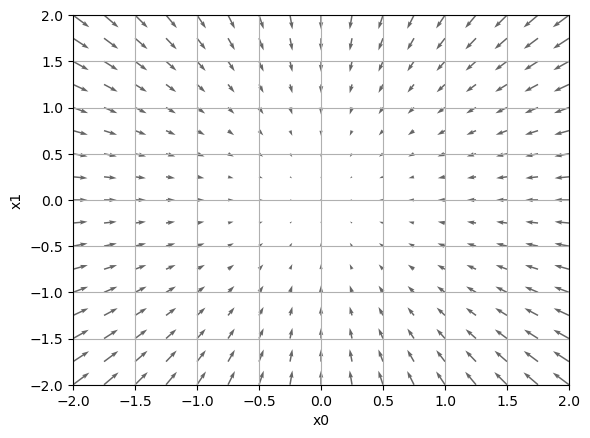

In [18]:
def f_2(x):
    if x.ndim == 1:
        return np.sum(x**2)
    return np.sum(x**2, axis=1)

def slope(f, x):
    d = numerical_diff(f, x)
    y = f(x) - d * x
    return lambda t: d * t + y

x0 = np.arange(-2.5, 2.5, 0.25)
x1 = np.arange(-2.5, 2.5, 0.25)
X, Y = np.meshgrid(x0, x1)
X, Y = X.flatten(), Y.flatten()

grad = numerical_gradient(f_2, np.array([X, Y]))

plt.figure()
plt.quiver(X, Y, -grad[0], -grad[1], angles="xy", color="#666666")# headwidth=10, scale=40, color="#444444")
plt.xlim([-2, 2])
plt.ylim([-2, 2])
plt.xlabel('x0')
plt.ylabel('x1')
plt.grid()
plt.draw()
plt.show()

### Gradient Descent - Chapter 4.4.1

In [19]:
def gradient_descent(f, init_x, lr=0.01, step_num=100):
    x = init_x
    
    for _ in range(step_num):
        x -= lr * numerical_gradient(f, x)

    return x

def gradient_descent_with_history(f, init_x, lr=0.01, step_num=100):
    x = init_x
    x_history = [x.copy()]
    
    for _ in range(step_num):
        x -= lr * numerical_gradient(f, x)
        x_history.append(x.copy())

    return x, np.array(x_history)

[-6.11110793e-10  8.14814391e-10]


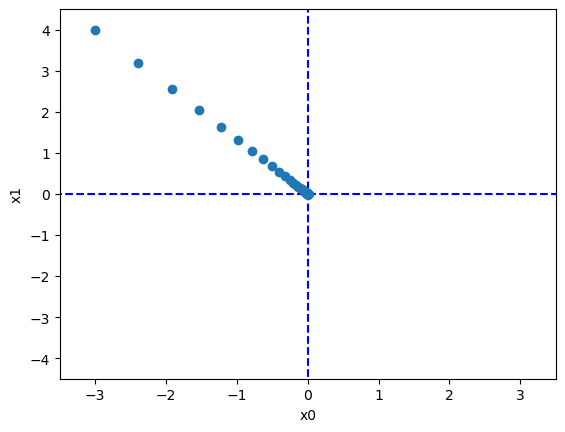

In [20]:
init_x = np.array([-3.0, 4.0])
x, x_history = gradient_descent_with_history(f_2, init_x, 0.1, 100)

print(x)

plt.plot([-5, 5], [0, 0], "--b")
plt.plot([0, 0], [-5, 5], "--b")
plt.plot(x_history[:,0], x_history[:,1], "o")
plt.xlim(-3.5, 3.5)
plt.ylim(-4.5, 4.5)
plt.xlabel("x0")
plt.ylabel("x1")
plt.show()

### Gradient in neural network

In [21]:
class SimpleNet:
    def __init__(self):
        self.W = np.random.randn(2, 3)

    def predict(self, X):
        return np.dot(X, self.W)

    def loss(self, X, T):
        return cee(softmax(self.predict(X)), T)

In [22]:
net = SimpleNet()
X = np.array([0.6, 0.9])
T = np.array([0, 0, 1])
print(f"network: {net.W}")
print(f"predict: {net.predict(X)}")
print(f"loss: {net.loss(X, T)}")

def _f(W):
    return net.loss(X, T)

dW = numerical_gradient(_f, net.W)
print(f"dW: {dW}")

network: [[-0.42023821  0.48277965  0.36087211]
 [-1.96816346  0.86226241 -0.61542947]]
predict: [-2.02349004  1.06570396 -0.33736326]
loss: 6.945517377988718
dW: [[-1.13652235  0.79385468  0.34266766]
 [-1.70478352  1.19078203  0.5140015 ]]


### Learning Algorithm - Chapter 4.5

In [23]:
class TwoLayerNet:
    def __init__(
        self, input_size: int, hidden_size: int, output_size: int, activation_fn, output_classifier, weight_init_std=0.01
    ) -> None:
        """Initialize Two Layer Network

        Args:
            input_size (int): size of input data
            hidden_size (int): size of hidden layer
            output_size (int): size of output
            activation_fn (function): an activation function for the network
            output_classifier (function): a function that classify the output
            weight_init_std (float, optional): initial weight. Defaults to 0.01.
        """
        self.params = {}
        self.params["W1"] = weight_init_std * np.random.randn(input_size, hidden_size)
        self.params["B1"] = np.zeros(hidden_size)
        self.params["W2"] = weight_init_std * np.random.randn(hidden_size, output_size)
        self.params["B2"] = np.zeros(output_size)

        self.activation_fn = activation_fn
        self.output_classifier = output_classifier

    def predict(self, X):
        W1, W2 = self.params["W1"], self.params["W2"]
        B1, B2 = self.params["B1"], self.params["B2"]

        Z = self.activation_fn(np.dot(X, W1) + B1)
        Y = self.output_classifier(np.dot(Z, W2) + B2)

        return Y

    def loss(self, X, T):
        return cee(self.predict(X), T)

    def accuracy(self, X, T):
        Y = self.predict(X)
        Y = np.argmax(Y, axis=1)
        T = np.argmax(T, axis=1)

        accuracy = np.sum(Y == T) / float(x.shape[0])

        return accuracy

    def numerical_gradient(self, X, T):
        loss = lambda _: self.loss(X, T)
        
        grads = {}
        grads["W1"] = numerical_gradient(loss, self.params["W1"])
        grads["B1"] = numerical_gradient(loss, self.params["B1"])
        grads["W1"] = numerical_gradient(loss, self.params["W1"])
        grads["B1"] = numerical_gradient(loss, self.params["B1"])

        return grads
        

In [24]:
network = TwoLayerNet(784, 50, 10, relu, softmax)
print(network.params["W1"].shape)
print(network.params["B1"].shape)
print(network.params["W2"].shape)
print(network.params["B2"].shape)

(784, 50)
(50,)
(50, 10)
(10,)


### Mini-Batch Learning

In [25]:
train_loss_list = []

# Hyper Parameter
iteration = 10000
train_size = X_train.shape[0]
batch_size = 100
learning_rate = 0.1

for i in range(iteration):
    batch_mask = np.random.choice(train_size, batch_size)
    X_batch = X_train[batch_mask]
    T_batch = T_train[batch_mask]
    
    grad = network.numerical_gradient(X_batch, T_batch)
    # grad = network.gradient(X_batch, T_batch) WIP
    
    for key in ("W1", "B1", "W2", "B2"):
        network.params[key] -= learning_rate * grad[key]
        
    loss = network.loss(X_batch, T_batch)
    train_loss_list.append(loss)

IndexError: arrays used as indices must be of integer (or boolean) type